# Esplorazione nella distribuzione lessicale

Codice ispirato a [Baayen (2008:243-250)](https://www.cambridge.org/highereducation/books/analyzing-linguistic-data/B2AF752A30911F4144CA35E075C6B233#overview)

Qui osserveremo la distribuzione delle parole-tipo (type) in un testo (la *Divina Commedia*) e in un [corpus di commenti YouTube](https://www.clarin.si/repository/xmlui/handle/11356/1450#) annotati per Hate Speech Detection. Il corpus è stato leggermente modificato per: 1. normalizzare problemi di spaziatura mancante 2. eliminare gli handler degli utenti

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set_style("darkgrid")
rcParams['figure.figsize'] = 12,9

## La Divina Commedia

In [2]:
import spacy
from scipy import stats

Creiamo un tokenizzatore

In [3]:
nlp = spacy.blank("it")
nlp.max_length = 20833854

Apriamo il file

In [4]:
with open('../data/commedia_cleaned.txt') as f:
    commedia = f.read()
comm = nlp(commedia)

Il tokenizzatore di `spacy` ha individuato all'incirca 130.000 token

In [5]:
len(comm)

135533

Ora eliminiamo i caratteri di nuova riga e i segni di punteggiatura

In [13]:
import re
# comm_toks = [c.lower_ for c in comm if not re.search(r'\n+', c.lower_) and not c.is_punct]
comm_toks = [c.lower_ for c in comm if c.lower_ != '\n' and not c.is_punct]

Rimangono circa 100.000 token

In [14]:
len(comm_toks)

101917

Creiamo un contatore per contare le frequenze delle parole-tipo (type)

In [16]:
from collections import Counter

c = Counter(comm_toks)
c.most_common(14)

[('e', 4065),
 ('che', 3697),
 ('la', 2360),
 ('a', 2045),
 ('di', 1897),
 ("l'", 1727),
 ('non', 1456),
 ('per', 1384),
 ('io', 1137),
 ('in', 1107),
 ('si', 1043),
 ("ch'", 1029),
 ('l', 951),
 ('le', 802)]

Questo è il codice che ho usato per calcolare la percentuale cumulativa dei primi *n* tipi di un testo

In [9]:
for i, (parola, freq) in enumerate(c.most_common(12), start=1):
    cum = sum([f[-1] for f in c.most_common(i)])
    perc = (cum / len(comm_toks) * 100)
    print(parola, freq, perc)

e 4065 3.993241451123314
che 3697 7.624979125121565
la 2360 9.94331856538012
a 2045 11.952218631197383
di 1897 13.815731308388262
l' 1727 15.512244958102892
non 1456 16.942542511075963
per 1384 18.302111064176742
io 1137 19.41903985382673
in 1107 20.50649822686327
si 1043 21.531086377791095
ch' 1029 22.541921667632643


Ora:
- trasformiamo i dati di frequenza in una tabella
- aggiungiamo 2 colonne con il logaritmo del rango e il logaritmo delle frequenze

Visualizziamo le prime 5 righe della tabella

In [10]:
import pandas as pd
import numpy as np


ranks = [i for i, _ in enumerate(c.most_common(), start=1)]
words = [w[0] for w in c.most_common()]
freqs = [w[1] for w in c.most_common()]

df = pd.DataFrame(data={'rank': ranks, 'freq': freqs, 'word': words})
df['log_rank'] = np.log(df['rank'])

df['log_freq'] = np.log(df['freq'])
df.head(10)

,rank,freq,word,log_rank,log_freq
0,1,4065,e,0.000000,8.310169
1,2,3697,che,0.693147,8.215277
2,3,2360,la,1.098612,7.766417
3,4,2045,a,1.386294,7.623153
4,5,1897,di,1.609438,7.548029
5,6,1727,l',1.791759,7.454141
6,7,1456,non,1.945910,7.283448
7,8,1384,per,2.079442,7.232733
8,9,1137,io,2.197225,7.036148
9,10,1107,in,2.302585,7.009409


Creaiamo una funzione per fare questa trasformazione più velocemente!

In [21]:
import pandas as pd
import numpy as np


def get_rank_table(type_counter):
    ranks = [i for i, _ in enumerate(type_counter.most_common(), start=1)]
    words = [w[0] for w in type_counter.most_common()]
    freqs = [w[1] for w in type_counter.most_common()]
    df = pd.DataFrame(data={'rank': ranks, 'freq': freqs, 'word': words})
    df['log_rank'] = np.log(df['rank'])
    df['log_freq'] = np.log(df['freq'])
    return df

newdf = get_rank_table(c)


newdf.head(10)

,rank,freq,word,log_rank,log_freq
0,1,4065,e,0.000000,8.310169
1,2,3697,che,0.693147,8.215277
2,3,2360,la,1.098612,7.766417
3,4,2045,a,1.386294,7.623153
4,5,1897,di,1.609438,7.548029
5,6,1727,l',1.791759,7.454141
6,7,1456,non,1.945910,7.283448
7,8,1384,per,2.079442,7.232733
8,9,1137,io,2.197225,7.036148
9,10,1107,in,2.302585,7.009409


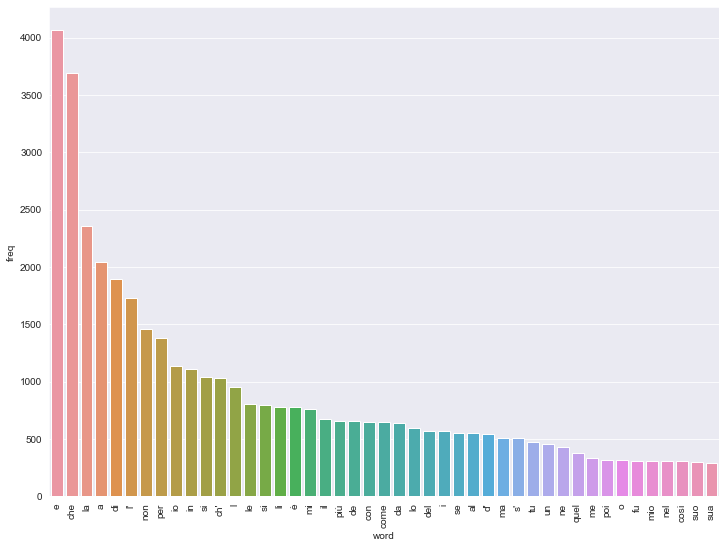

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.barplot(x='word', y='freq', data=df.iloc[:45])
#ax.set_xticklabels([w[0] for w in c.most_common(50)])
ax.tick_params(axis='x', rotation=90)
plt.show()

Qui creiamo il grafico in scala log/log, lasciando che una libreria python (`seaborn`) si occupi della regressione (disegnando la retta ideale)

<Axes: xlabel='log_rank', ylabel='log_freq'>

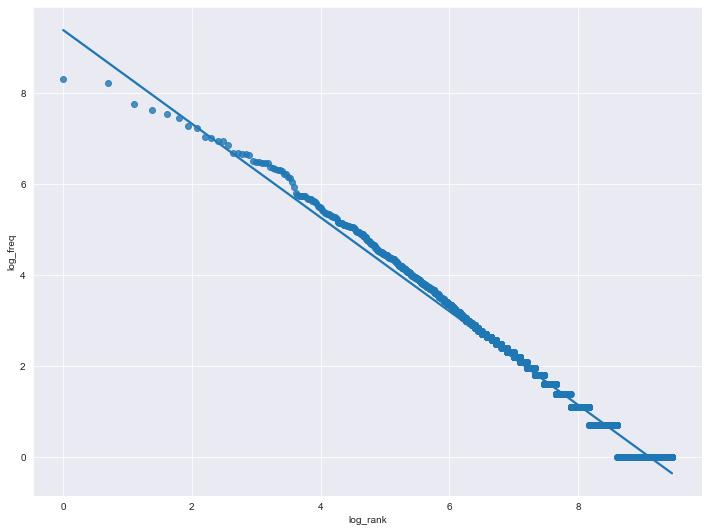

In [15]:
sns.regplot(data = df, x='log_rank', y='log_freq')

Possiamo avere informazioni più precise sulla pendenza e intercetto della regressione:

In [183]:
slope, intercept, r, p, std_err = stats.linregress(df.log_rank, df.log_freq)
print(slope)

-1.0301318191529754


## Il corpus di commenti su YouTube per la Hate Speech detection

Scaricato da [CLARIN](https://hdl.handle.net/11356/1450) e "normalizzato" leggermente (vedi sopra).

Per prima cosa, apriamo il file (compresso) TAR

In [17]:
import tarfile

tar = tarfile.open("../data/youtube_hate.tar.gz")
with tar.extractfile('youtube_hate.txt') as f:
    corpus = f.read().decode('utf8')
tar.close()

Ora facciamo la tokenizzazione! (potrebbe richiedere un po' di tempo)

In [18]:
toks = nlp(corpus)

Come prima per Dante, scartiamo i caratteri di nuova riga (\n) e la punteggiatura 

In [19]:
yt_toks = [c.lower_ for c in toks if not re.search(r'\n+', c.lower_) and c.is_alpha]
print(len(yt_toks))

1632113


Creiamo il contatore delle frequenze e vediamo le 20 parole più frequenti. Paragoniamole alle 20 più frequenti in Dante

In [20]:
cyt = Counter(yt_toks)
for yt, dante in zip(cyt.most_common(20), c.most_common(20)):
    print(f'{yt[0]} ({yt[1]})\t{dante[0]} ({dante[1]})')

e (47099)	e (4065)
che (44996)	che (3697)
di (42405)	la (2360)
non (32884)	a (2045)
il (28953)	di (1897)
la (28648)	l' (1727)
a (28212)	non (1456)
in (23955)	per (1384)
è (20855)	io (1137)
per (20081)	in (1107)
i (18675)	si (1043)
un (17851)	ch' (1029)
ma (15169)	l (951)
sono (13716)	le (802)
si (13230)	sì (796)
le (12354)	li (781)
da (10959)	è (778)
con (10875)	mi (760)
ci (10355)	il (671)
se (9971)	più (661)


In [22]:
ytdf = get_rank_table(cyt)
ytdf.head()

,rank,freq,word,log_rank,log_freq
0,1,47099,e,0.000000,10.760007
1,2,44996,che,0.693147,10.714329
2,3,42405,di,1.098612,10.655022
3,4,32884,non,1.386294,10.400741
4,5,28953,il,1.609438,10.273429


<Axes: xlabel='log_rank', ylabel='log_freq'>

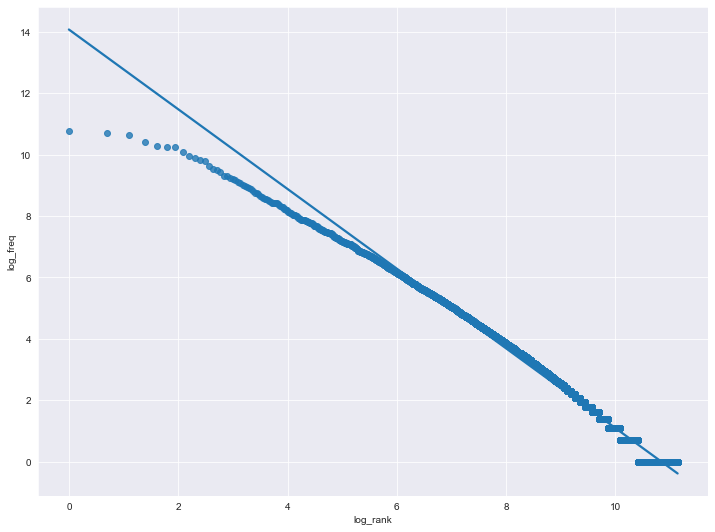

In [25]:
sns.regplot(data = ytdf, x='log_rank', y='log_freq')

## La lista delle parole de *la Repubblica*

Dal motore NoSketchEngine è possibile scaricare la lista delle parole tipo del corpus Repubblica. Proviamo a vedere la distribuzione

In [29]:
import pandas as pd
df = pd.read_csv('../data/wordlist_repubblica.zip')
df.head()


,Item,Frequency
0,",",21095417
1,.,14708032
2,di,12649968
3,e,7934223
4,il,7227432


Filtriamo i segni di punteggiatura

In [40]:
import string
dff = df[~df['Item'].str[0].isin(list(string.punctuation))]

In [41]:
dff.head()

,Item,Frequency
2,di,12649968
3,e,7934223
4,il,7227432
5,la,6572308
6,che,6442608


In [42]:
dff['rank'] = [e for e, _ in enumerate(dff.index, start=1)]
dff.head()

/var/folders/m7/cdsvqlhs2715rg1dhl8hm35r0000gp/T/ipykernel_22268/2651316746.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['rank'] = [e for e, _ in enumerate(dff.index, start=1)]


,Item,Frequency,rank
2,di,12649968,1
3,e,7934223,2
4,il,7227432,3
5,la,6572308,4
6,che,6442608,5


In [43]:
dff['log_rank'] = np.log(dff['rank'])
dff['log_freq'] = np.log(dff['Frequency'])
dff.head()

/var/folders/m7/cdsvqlhs2715rg1dhl8hm35r0000gp/T/ipykernel_22268/2049694484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['log_rank'] = np.log(dff['rank'])
/var/folders/m7/cdsvqlhs2715rg1dhl8hm35r0000gp/T/ipykernel_22268/2049694484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['log_freq'] = np.log(dff['Frequency'])


,Item,Frequency,rank,log_rank,log_freq
2,di,12649968,1,0.000000,16.353165
3,e,7934223,2,0.693147,15.886696
4,il,7227432,3,1.098612,15.793394
5,la,6572308,4,1.386294,15.698376
6,che,6442608,5,1.609438,15.678444


<Axes: xlabel='log_rank', ylabel='log_freq'>

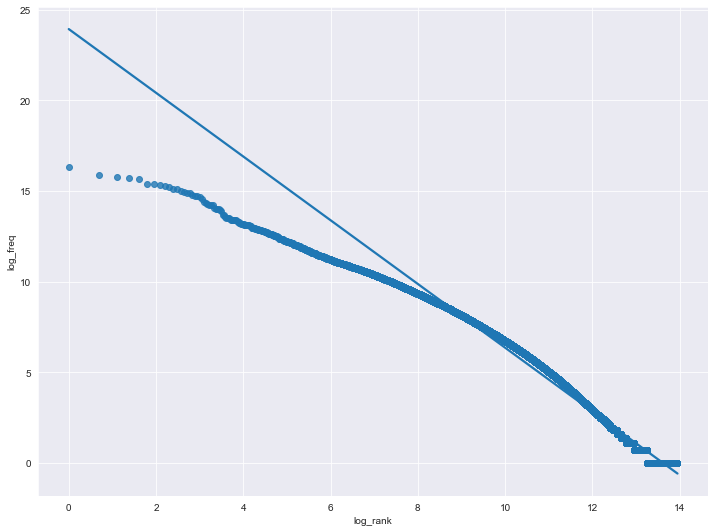

In [44]:
sns.regplot(data = dff, x='log_rank', y='log_freq')

## Esplorare le concordanze con `NLTK`

Esploriamo le conconrdanze del corpus di Hate Speech detection con la libreria che abbiamo già usato nella lezione sulla tokenizzazione, `NLTK`. NLTK offre una classe apposita (`Text`) per esplorare i dati testuali, utilizzando concordanze e collocazioni

In [20]:
from nltk import Text

Creiamo un'istanza della classe `Text` con la lista dei token del nostro corpus

In [21]:
t = Text(yt_toks)

E ora cerchiamo la chiave "buono"

In [22]:
t.concordance('buono')

Displaying 25 of 135 matches:
egno che si dovrà pagare qualcosa di buono è capiamo di essere uno tutti colleg
atto il governo italiano per anni di buono per italia tanto peggio di prima non
l mio paese stanno aiutando dando di buono spesa alla settimana per le famiglie
cittadini italiani il governo è solo buono a chiedere soldi vergogna tutti ness
 mascherina che cosa fanno in giro è buono vero una italia con gente civilizzat
 o più niente da perdere se nn sarei buono con le mani ci sono altri metodi x m
formazioni avanti cosi certo sarebbe buono sapere la situazione e il pensiero n
 mister no e già sai ogni appiglio e buono stia tranquilla signora al mondo ci 
n fosse per il mio sadismo sarei più buono con loro ma proprio non ce la faccio
to di patente unico comunista cinese buono è quello morto la mia livorno italia
io schiacallare ora che e il momento buono infatti la meloncina sale di consens
agire subito italexit almeno il lato buono della cosa un di pulizia delle zone 
ro diceva 

Di default, il metodo che stampa le concordanze a video lavora con una finestra di 80 caratteri e mostra 25 righe. Possiamo modificare questi parametri:

In [23]:
t.concordance('buono', width=150, lines=30)

Displaying 30 of 135 matches:
lo ma questo è il sacrificio o il pegno che si dovrà pagare qualcosa di buono è capiamo di essere uno tutti collegati fisicamente a prescindere della
i ma poi parliamoci chiaro che ha fatto il governo italiano per anni di buono per italia tanto peggio di prima non si poteva andare magari andiamo me
ano i primi ad essere colpiti qui al mio paese stanno aiutando dando di buono spesa alla settimana per le famiglie ottima iniziativa pratola serra av
esiste auto assistenzialismo tra i cittadini italiani il governo è solo buono a chiedere soldi vergogna tutti nessun fenomeno che adesso rompe il caz
nopersone con i figli piccoli senza mascherina che cosa fanno in giro è buono vero una italia con gente civilizzata inizio sono stati provati e poi r
rei male a una mosca oggi giorno nn o più niente da perdere se nn sarei buono con le mani ci sono altri metodi x mandare al cimitero una verme io o u
n casa ciao grazie x i dati e le informazioni avanti cosi certo sarebb

Possiamo anche cercare sequenze di più token

In [24]:
t.concordance(["nulla", 'di', "buono"])

Displaying 5 of 5 matches:
isce unione europea non ha dato nulla di buono italia penso che italia possa r
cazzo in anni non ci ha portato nulla di buono apparte debiti loro sono il ver
oicottata piuttosto che seguita nulla di buono arriverà dalla escluso giletti 
a del signore non possiamo fare nulla di buono e naturalmente mettendoci il no
ria mi puzza parecchio non vedo nulla di buono mi spiace per i giovani che se 


Ma come funziona la generazione delle concordanze? Il metodo genera un indice (`_concordance_list`) dell'istanza dove viene mappato ogni tipo alle sue posizioni nel testo.

Vediamo ad es. gli "offsets" (ovvero l'indice numerico) della parola "buono":

In [25]:
t._concordance_index._offsets['buono'][:5]

[3468, 12129, 27913, 28857, 34086]

Vediamo il primo:

In [194]:
print(yt_toks[75763])

buono


## Espressioni Regolari

`NLTK` mette a disposizione anche un interessante classe (`TokenSearcher`) per fare ricerche usando le espressioni regolari su una lista di token.
 
 La sintassi delle regex è la medesima che abbiamo visto a lezione, ma i token vanno scritti tra parentesi uncinate `<>`.

 Ad esempio: cerchiamo le sequenze *un buon x* o *una buona x* nel nostro corpus utilizzando le espressioni regolari

In [26]:
from nltk.text import TokenSearcher

In [27]:
tsearch =  TokenSearcher(yt_toks)
tsearch.findall('<un[ao]?><buon[ao]><.*>')

[['una', 'buona', 'serata'],
 ['una', 'buona', 'scuola'],
 ['una', 'buona', 'giornata'],
 ['una', 'buona', 'occasione'],
 ['una', 'buona', 'ragione'],
 ['una', 'buona', 'volta'],
 ['uno', 'buono', 'da'],
 ['una', 'buona', 'serata'],
 ['una', 'buona', 'vita'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'scusa'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'cosa'],
 ['una', 'buona', 'giornata'],
 ['una', 'buona', 'compagnia'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'volta'],
 ['un', 'buono', 'per'],
 ['una', 'buona', 'idea'],
 ['una', 'buona', 'leva'],
 ['una', 'buona', 'salute'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'percentuale'],
 ['una', 'buona', 'causa'],
 ['una', 'buona', 'giornata'],
 ['una', 'buona', 'idea'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'giornata'],
 ['una', 'buona', 'dose'],
 ['una', 'buona', 'idea'],
 ['una', 'buona', 'fetta'],
 ['una', 'buona', 'zona'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'alimentazio

Possiamo aggregare e contare i nomi per avere una specie di statistica:

In [28]:
res = tsearch.findall('<un[ao]?><buon[ao]>(<.*>)')
ctok = Counter([r[0] for r in res])
ctok.most_common(20)

[('parte', 16),
 ('volta', 12),
 ('serata', 11),
 ('giornata', 9),
 ('idea', 4),
 ('a', 3),
 ('guarigione', 3),
 ('notizia', 3),
 ('scuola', 2),
 ('occasione', 2),
 ('ragione', 2),
 ('per', 2),
 ('percentuale', 2),
 ('da', 1),
 ('vita', 1),
 ('scusa', 1),
 ('cosa', 1),
 ('compagnia', 1),
 ('leva', 1),
 ('salute', 1)]

# Collocations

In [29]:
from nltk import collocations
from nltk.collocations import BigramAssocMeasures

bigram_measures = BigramAssocMeasures()

In [35]:
finder = collocations.BigramCollocationFinder.from_words(yt_toks)
finder.apply_freq_filter(10)
finder.nbest(bigram_measures.pmi, 20)

[('angiolina', 'belloni'),
 ('hong', 'kong'),
 ('class', 'action'),
 ('helicopter', 'money'),
 ('trevor', 'saba'),
 ('radical', 'chic'),
 ('nadia', 'agostin'),
 ('spina', 'dorsale'),
 ('urbino', 'urbano'),
 ('flash', 'mob'),
 ('sd', 'free'),
 ('squalifica', 'squalifica'),
 ('piazzale', 'loreto'),
 ('edi', 'rama'),
 ('turni', 'massacranti'),
 ('cassandra', 'paris'),
 ('extra', 'comunitari'),
 ('monica', 'castagna'),
 ('dogma', 'revolution'),
 ('frecce', 'tricolori')]

In [38]:
finder = collocations.BigramCollocationFinder.from_words(yt_toks)
# finder.apply_freq_filter(5)
finder.nbest(bigram_measures.likelihood_ratio, 20)

[('a', 'casa'),
 ('gli', 'italiani'),
 ('quello', 'che'),
 ('in', 'italia'),
 ('il', 'virus'),
 ('ci', 'sono'),
 ('tutti', 'i'),
 ('i', 'nostri'),
 ('corona', 'virus'),
 ('tutte', 'le'),
 ('non', 'è'),
 ('gli', 'altri'),
 ('la', 'gente'),
 ('in', 'giro'),
 ('popolo', 'italiano'),
 ('unione', 'europea'),
 ('il', 'governo'),
 ('la', 'nostra'),
 ('non', 'si'),
 ('di', 'merda')]

In [39]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('italian'))

In [40]:
word_filter = lambda w: w in stop_words

In [41]:
finder = collocations.BigramCollocationFinder.from_words(yt_toks)
finder.apply_word_filter(word_filter)
finder.nbest(bigram_measures.likelihood_ratio, 20)

[('corona', 'virus'),
 ('popolo', 'italiano'),
 ('unione', 'europea'),
 ('forze', 'ordine'),
 ('bla', 'bla'),
 ('forza', 'italia'),
 ('com', 'watch'),
 ('secondo', 'me'),
 ('youtube', 'com'),
 ('watch', 'v'),
 ('altri', 'paesi'),
 ('vuol', 'dire'),
 ('ogni', 'giorno'),
 ('terapia', 'intensiva'),
 ('troppo', 'tardi'),
 ('de', 'luca'),
 ('maggior', 'parte'),
 ('va', 'bene'),
 ('grazie', 'mille'),
 ('zona', 'rossa')]

In [45]:
finder.score_ngram(BigramAssocMeasures.likelihood_ratio, 'zona', 'rossa')

1503.7520544064232

In [46]:
finder.score_ngram(BigramAssocMeasures.likelihood_ratio, 'gente', 'muore')

387.70701982284663

### Subtitle of Game of Thrones

In [47]:
from nltk.corpus import PlaintextCorpusReader

In [54]:
gtcorpus = PlaintextCorpusReader(root="/Users/francesco.mambrini/Downloads/gt_subtitles", fileids=r"season[0-9].txt")
len(gtcorpus.fileids())

7

In [58]:
import string

gttoks = [c.lower() for c in gtcorpus.words() if c not in string.punctuation]

stop_words = set(stopwords.words('english'))


finder = collocations.BigramCollocationFinder.from_words(gttoks)
finder.apply_word_filter(word_filter)
finder.nbest(bigram_measures.likelihood_ratio, 20)

[('seven', 'kingdoms'),
 ('jon', 'snow'),
 ('font', 'color'),
 ('castle', 'black'),
 ('casterly', 'rock'),
 ('color', '="#'),
 ('lord', 'commander'),
 ('ned', 'stark'),
 ('iron', 'throne'),
 ('white', 'walkers'),
 ('iron', 'islands'),
 ('</', 'font'),
 ('shame', 'shame'),
 ('tywin', 'lannister'),
 ('mhysa', 'mhysa'),
 ('robb', 'stark'),
 ('ser', 'davos'),
 ('lord', 'baelish'),
 ('small', 'council'),
 ('ec14bd', '">')]

### Log Dice

Let us set the variable `toks` to whatever list of tokens we want to work with

In [103]:
toks = yt_toks

In [104]:
import math

def log_dice(f12, f1, f2):
    """Calculate the Log Dice correlation measure."""
    return 14 + math.log2((2 * f12) / (f1 + f2))

In [105]:
from nltk import FreqDist

In [106]:
fdist = FreqDist(toks)

In [107]:
fdist.most_common(10)

[('e', 47099),
 ('che', 44996),
 ('di', 42405),
 ('non', 32884),
 ('il', 28953),
 ('la', 28648),
 ('a', 28212),
 ('in', 23955),
 ('è', 20855),
 ('per', 20081)]

In [114]:
finder = collocations.BigramCollocationFinder.from_words(toks)
threshold = 15
finder.apply_freq_filter(threshold)

This helps me getting `f12`

In [115]:
print(f"Bigram (f12) frequency: {finder.ngram_fd[('i', 'am')]}")
print(f"First-item (f1) frequency: {fdist['i']}")
print(f"Second-item (f2) frequency: {fdist['am']}")

Bigram (f12) frequency: 0
First-item (f1) frequency: 18675
Second-item (f2) frequency: 13


In [116]:
finder.ngram_fd[('i', 'am')]

0

In [117]:
ldices = {}
for big, c in finder.ngram_fd.items():
    f12 = c
    f1 = fdist[big[0]]
    f2 = fdist[big[1]]
    score = log_dice(f12, f1, f2)
    ldices[big] = score

In [118]:
ldices[('don', 't')]

KeyError: ('don', 't')

In [119]:
ldf = FreqDist(ldices)

In [120]:
ldf.most_common(50)

[(('task', 'force'), 13.830074998557688),
 (('terapia', 'intensiva'), 13.827163403137785),
 (('flash', 'mob'), 13.79054663437105),
 (('difese', 'immunitarie'), 13.777607578663552),
 (('nik', 'lang'), 13.777607578663552),
 (('dogma', 'revolution'), 13.736965594166206),
 (('scie', 'chimiche'), 13.697437229979569),
 (('luisa', 'cerutti'), 13.691877704637669),
 (('new', 'york'), 13.665580960929441),
 (('tiziana', 'mantino'), 13.633217669328378),
 (('terapie', 'intensive'), 13.62148837674627),
 (('carri', 'armati'), 13.60407132366886),
 (('watch', 'v'), 13.583665696102704),
 (('kill', 'dogma'), 13.534336427651189),
 (('von', 'der'), 13.532873989572701),
 (('lina', 'faccani'), 13.485426827170242),
 (('arresti', 'domiciliari'), 13.485426827170242),
 (('aldo', 'moro'), 13.460841188891969),
 (('bla', 'bla'), 13.430212493113087),
 (('bill', 'gates'), 13.415037499278844),
 (('com', 'watch'), 13.409583069186736),
 (('der', 'leyen'), 13.39592867633114),
 (('unione', 'europea'), 13.30485458152842),
